In [22]:
!pip install geomle
!pip install scanpy==0.2.3.5
!pip install Shapely

  Using cached https://files.pythonhosted.org/packages/2b/b8/2b8b1af1883251ea7831bae91af7d8680455b8c4b9d8c472c7ca2526f678/scanpy-0.2.3.5.tar.gz
  ERROR: Command errored out with exit status 1:
   command: /home/utilisateur/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-8y_aeqjs/scanpy/setup.py'"'"'; __file__='"'"'/tmp/pip-install-8y_aeqjs/scanpy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-hqeod85e --python-tag cp37
       cwd: /tmp/pip-install-8y_aeqjs/scanpy/
  Complete output (133 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.7
  creating build/lib.linux-x86_64-3.7/scanpy
  copying scanpy/readwrite.py -> build/lib.linux-x86_64-3.7/scanpy
  copying scanpy/__main__.py -> build/lib.linux-x86_64-3.7/scanpy
  

In [27]:
import sys
import os
from os import path
current_folder = path.dirname(path.abspath('')) 
sys.path.append(current_folder)
from estimators import *
from geomle import geomle, mle, DataGenerator
import re
import seaborn as sns
import scanpy.api as sc
from sklearn.preprocessing import LabelEncoder
import multiprocessing as mp
import multiprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import cholesky
from scipy.special import gammainc, lambertw
import scipy.io
import matplotlib as mpl
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import random
import time
import numpy as np
import pandas as pd
import pickle
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
from functools import wraps
import subprocess
from IPython.display import display_html
from operator import itemgetter
ig0 = itemgetter(0)
ig1 = itemgetter(1)
ig2 = itemgetter(2)
rpy2.robjects.numpy2ri.activate()
utils = rpackages.importr('utils')
#utils.install_packages('intrinsicDimension')
#utils.install_packages('ider')
intdimr = rpackages.importr('intrinsicDimension')
ider   = rpackages.importr('ider')
r_base = rpackages.importr('base')

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def mean_sqe(estimations, truth):
    '''
    Mean squared error 
    '''
    return ((estimations - truth)^2/truth).sum() /len(truth) 
    
def mean_pe(estimations, truth):
    '''
    Mean percentage error 
    '''
    return (abs(estimations - truth)/truth).sum() /len(truth)*100

def mean_ge(estimations, truth):
    '''
    Mean geometric error: The geometric mean of the error *ratio*. It is always >= 1.
    '''
    ratios = np.concatenate(((estimations/truth)[np.newaxis, :], (truth/estimations)[np.newaxis, :]), axis=0)
    return np.power(ratios.max(axis=0).prod(), 1.0/len(estimations))

def med_pe(estimations, truth):
    '''
    Median error in %.
    '''
    return np.percentile(abs(estimations - truth)/truth, q=50)*100


def randball(n_points,ndim,radius,center = []):
    ''' Generate uniformly sampled ndim-sphere interior'''
    if center == []:
        center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def proxy(tup):
    function,X,Dict = tup
    return function(X,**Dict)

def get_nn(X,k,n_jobs=1):
    neigh = NearestNeighbors(n_neighbors=k,n_jobs=n_jobs)
    neigh.fit(X)
    dists, inds = neigh.kneighbors(return_distance=True)
    return dists,inds

def asPointwise(data,function, params, precomputed_knn = None, n_neighbors=100, n_jobs=1):
    '''Use a global estimator as a pointwise one by creating kNN neighborhoods'''
    if precomputed_knn is not None:
        knn = precomputed_knn
    else:
        _, knn = get_nn(data, k=n_neighbors, n_jobs=n_jobs)
        
    if n_jobs > 1:
        pool = mp.Pool(n_jobs)
        results = pool.map(proxy,[(function,data[i,:],params) for i in knn])
        pool.close()
        return results
    else:
        return [function(data[i,:],**params) for i in knn]


from functools import wraps
def calculate_time(func): 
    @wraps(func)
    def inner_func(*args, **kwargs): 
        begin = time.time() 
        res = func(*args, **kwargs) 
        end = time.time()
        return res, end - begin
    return inner_func

class DimEst():
    def __init__(self):
        self.names = ['MLE', 'GeoMLE', 'MIND', 'DANCo', 'FastDANCo', 'ESS', 'PCA', 'CD','FisherS','ANOVA','TwoNN']
        self.caldatas = {}
        
    def estimateAllMethods(self, data,ConditionalNumber=10):
        dim = data.shape[1]
        self.funcs = {'MLE':          self.mle(data),
                      #'GeoMLE':       self.geomle(data, dim),
                      #'DANCo':        self.danco(data, dim),
                      'FastDANCo':    self.fast_danco(data),
                      'ESS':          self.ess(data),
                      'PCA':          self.pca(data),
                      #'CD':           self.cd(data),
                      'FisherS':      self.fisherS(data,ConditionalNumber),
                      'ANOVA':        self.anova(data),
                      'TwoNN':        self.twonn(data)
                     }
                      
        self.times = {key: ig1(val) for key, val in self.funcs.items()}
        self.funcs = {key: ig0(val) for key, val in self.funcs.items()}
        return self.funcs, self.times
    
    def estimateAllMethodsLocally(self, data, k, n_jobs = 1, ConditionalNumber = 10):
        dim = data.shape[1]
        
        _, knn = get_nn(data, k, n_jobs)
        
        mle_pw, tle_pw, mom_pw, ed_pw, ged_pw, pca_pw, mind_mlk_pw, mind_mli_pw = self.rado_ests(data,k).values()
        self.funcs = {'MLE':           self.mlelocal(data,k),
                      #'GeoMLE':        self.geomlelocal(data, dim),
                      #'mind_mlk':          asPointwise(data,self.mind_mlk,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      #'mind_mli':          asPointwise(data,self.mind_mli,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      #'DANCo':         asPointwise(data,self.danco,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      'FastDANCo':     self.fast_dancoloop(data),
                      'ESS':           asPointwise(data,self.ess,{},precomputed_knn=knn,n_jobs=n_jobs),
                      'PCA':           asPointwise(data,self.pca,{},precomputed_knn=knn,n_jobs=1),
                      'CD':            asPointwise(data,self.lcd,{},precomputed_knn=knn,n_jobs=n_jobs),
                      'FisherS':       asPointwise(data,self.fisherS,{'ConditionalNumber':ConditionalNumber},precomputed_knn=knn,n_jobs=n_jobs),
                      'FisherSglobpw': self.fisherS(data,ConditionalNumber,global_pw=True),
                      'ANOVA':         self.anovalocal(data,k),
                      'TwoNN':         asPointwise(data,self.twonn,{},precomputed_knn=knn,n_jobs=n_jobs),
                      'radoMLE':       mle_pw,
                      'radoTLE':       tle_pw,
                      'radoMOM':       mom_pw,
                      'radoED':        ed_pw,
                      'radoGED':       ged_pw,
                      'radoPCA':       pca_pw,
                      'radoMINDmlk':   mind_mlk_pw,
                      'radoMINDmli':   mind_mli_pw,

                     }
                      
        self.times = {}
        for key, val in self.funcs.items():
            if key in ['MLE','ANOVA','FastDANCo','FisherSglobpw']:
                self.funcs[key] = np.array(val[0])
                self.times[key] = val[1]
            elif 'rado' in key:
                self.funcs[key] = np.array(val)
            else:
                self.funcs[key] = np.array([i[0] for i in val])
                self.times[key] = np.sum([i[1] for i in val])
            
        return self.funcs, self.times
    
    
    @staticmethod
    def rado_ests(data,k):
        return radovanovic_estimators_matlab(data,k=k)
    
    @staticmethod
    @calculate_time
    def mle(data):
        return intdimr.maxLikGlobalDimEst(data,k=20).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def mlelocal(data,k):
        res = intdimr.maxLikPointwiseDimEst(data,k=k)
        return np.array([i[0] for i in res])

    @staticmethod
    @calculate_time
    def geomle(data, dim):
#         k1 =  k1_log(dim)
#         k2 =  k2_log(dim)
        return geomle(pd.DataFrame(data), k1=20, k2=55, nb_iter1=1, alpha=5e-3).mean()

    @staticmethod
    @calculate_time
    def geomlelocal(data, dim):
#         k1 =  k1_log(dim)
#         k2 =  k2_log(dim)
        return geomle(pd.DataFrame(data), k1=20, k2=55, nb_iter1=1, alpha=5e-3)
    
    @staticmethod
    @calculate_time
    def mind_mlk(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="MIND_MLk").rx2('dim.est')[0]
    

    @staticmethod
    @calculate_time
    def mind_mli(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="MIND_MLi").rx2('dim.est')[0]
    
    #@staticmethod
    @calculate_time
    def danco(self,data, dim):
        try:
            res = intdimr.dancoDimEst(data, k=10, D=min(dim,100), calibration_data = self.caldatas[len(data)], ver="DANCo")
            self.caldatas[len(data)]=res[2]
            return res.rx2('dim.est')[0]
        except:
            res = intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="DANCo")
            self.caldatas[len(data)]=res[2]
            return res.rx2('dim.est')[0]

    @staticmethod
    @calculate_time
    def fast_danco(data):
        return runDANCo(data)[0]
    
    @staticmethod
    @calculate_time
    def fast_dancoloop(data):
        return runDANColoop(data)
    
    @staticmethod
    @calculate_time
    def ess(data):
        return ess_py(data)[0]
    
    @staticmethod
    @calculate_time
    def pca(data):
        return intdimr.pcaLocalDimEst(data, 'FO', alphaFO = .1).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def cd(data):
        return corint_py(data, k1=10, k2=20)[0]
    
    @staticmethod
    @calculate_time
    def lcd(data):
        return corint_py(data, k1=10, k2=len(data)-1)[0]
    
    @staticmethod
    @calculate_time
    def fisherS(data,ConditionalNumber,global_pw=False):
        if global_pw:
            n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,ProducePlots=0,alphas=np.arange(.2,1,.02)[None],ConditionalNumber=ConditionalNumber)
            n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected',force_definite_dim=False,verbose=False)
            return n_pointwise
        else:
            return SeparabilityAnalysis(data,ProducePlots=0,alphas=np.arange(.2,1,.02)[None],ConditionalNumber=ConditionalNumber)[1][0]
    
    @staticmethod
    @calculate_time
    def anova(data):
        return runANOVAglobal(data)[0,0]
    
    @staticmethod
    @calculate_time
    def anovalocal(data,k):
        return runANOVAlocal(data,k=k)[:,0]
    
    @staticmethod
    @calculate_time
    def twonn(data):
        res = twonn_py(data)
        return res    

In [17]:
import shapely.geometry as geom
from statsmodels.nonparametric.smoothers_lowess import lowess

def project_point_to_curve_distance(XP,p):
    curve = geom.LineString(XP)
    point = geom.Point(p)
    #distance from point to curve
    dist_p_to_c = point.distance(curve)
    return dist_p_to_c

def filter_genes(adata,min_num_cells = 5,min_pct_cells = None,min_count = None, expr_cutoff = 1):
    """Filter out genes based on different metrics.
    Parameters
    ----------
    adata: AnnData
        Annotated data matrix.
    min_num_cells: `int`, optional (default: None)
        Minimum number of cells expressing one gene
    min_pct_cells: `float`, optional (default: None)
        Minimum percentage of cells expressing one gene
    min_count: `int`, optional (default: None)
        Minimum number of read count for one gene
    expr_cutoff: `float`, optional (default: 1)
        Expression cutoff. If greater than expr_cutoff,the gene is considered 'expressed'
    Returns
    -------
    updates `adata` with a subset of genes that pass the filtering.      
    """

    n_counts = np.sum(adata.X,axis=0)
    adata.var['n_counts'] = n_counts
    n_cells = np.sum(adata.X>expr_cutoff,axis=0)
    adata.var['n_cells'] = n_cells 
    if(sum(list(map(lambda x: x is None,[min_num_cells,min_pct_cells,min_count])))==3):
        print('No filtering')
    else:
        gene_subset = np.ones(len(adata.var_names),dtype=bool)
        if(min_num_cells!=None):
            print('Filter genes based on min_num_cells')
            gene_subset = (n_cells>min_num_cells) & gene_subset
        if(min_pct_cells!=None):
            print('Filter genes based on min_pct_cells')
            gene_subset = (n_cells>adata.shape[0]*min_pct_cells) & gene_subset
        if(min_count!=None):
            print('Filter genes based on min_count')
            gene_subset = (n_counts>min_count) & gene_subset 
        adata._inplace_subset_var(gene_subset)
        print('After filtering out low-expressed genes: ')
        print(str(adata.shape[0])+' cells, ' + str(adata.shape[1])+' genes')
    return None


def filter_cells(adata,min_num_genes = 10,min_pct_genes = None,min_count=None,expr_cutoff = 1):
    """Filter out cells based on different metrics.
    Parameters
    ----------
    adata: AnnData
        Annotated data matrix.
    min_num_genes: `int`, optional (default: None)
        Minimum number of genes expressed
    min_pct_genes: `float`, optional (default: None)
        Minimum percentage of genes expressed
    min_count: `int`, optional (default: None)
        Minimum number of read count for one cell
    expr_cutoff: `float`, optional (default: 1)
        Expression cutoff. If greater than expr_cutoff,the gene is considered 'expressed'
    Returns
    -------
    updates `adata` with a subset of cells that pass the filtering.      
    """

    n_counts = np.sum(adata.X,axis=1)
    adata.obs['n_counts'] = n_counts
    n_genes = np.sum(adata.X>=expr_cutoff,axis=1)
    adata.obs['n_genes'] = n_genes
    if(sum(list(map(lambda x: x is None,[min_num_genes,min_pct_genes,min_count])))==3):
        print('No filtering')    
    else:
        cell_subset = np.ones(len(adata.obs_names),dtype=bool)
        if(min_num_genes!=None):
            print('filter cells based on min_num_genes')
            cell_subset = (n_genes>=min_num_genes) & cell_subset
        if(min_pct_genes!=None):
            print('filter cells based on min_pct_genes')
            cell_subset = (n_genes>=adata.shape[0]*min_pct_genes) & cell_subset
        if(min_count!=None):
            print('filter cells based on min_count')
            cell_subset = (n_counts>=min_count) & cell_subset 
        adata._inplace_subset_obs(cell_subset)
        print('after filtering out low-expressed cells: ')
        print(str(adata.shape[0])+' cells, ' + str(adata.shape[1])+' genes')
    return None


def log_transform(adata,base=2):
    """Logarithmize gene expression.
    Parameters
    ----------
    adata: AnnData
        Annotated data matrix.
    base: `int`, optional (default: 2)
        The base used to calculate logarithm
    Returns
    -------
    updates `adata` with the following fields.
    X: `numpy.ndarray` (`adata.X`)
        Store #observations × #var_genes logarithmized data matrix.
    """

    adata.X = np.log2(adata.X+1)/np.log2(base)
    return None


def normalize_per_cell(adata):
    """Normalize gene expression based on library size.
    Parameters
    ----------
    adata: AnnData
        Annotated data matrix.
    Returns
    -------
    updates `adata` with the following fields.
    X: `numpy.ndarray` (`adata.X`)
        Store #observations × #var_genes normalized data matrix.
    """
    adata.X = (np.divide(adata.X.T,adata.X.sum(axis=1)).T)*1e6


def remove_mt_genes(adata):
    """remove mitochondrial genes.
    Parameters
    ----------
    adata: AnnData
        Annotated data matrix.
    Returns
    -------
    updates `adata` with a subset of genes that excluded mitochondrial genes.
    """        

    r = re.compile("^MT-",flags=re.IGNORECASE)
    mt_genes = list(filter(r.match, adata.var_names))
    if(len(mt_genes)>0):
        print('remove mitochondrial genes:')
        print(mt_genes)
        gene_subset = ~adata.var_names.isin(mt_genes)
        adata._inplace_subset_var(gene_subset)


def select_variable_genes(adata,loess_frac=0.01,percentile=95,n_genes = None,n_jobs = multiprocessing.cpu_count(),
                          save_fig=False,fig_name='std_vs_means.pdf',fig_path=None,fig_size=(5,5)):

    """Select the most variable genes.
    Parameters
    ----------
    adata: AnnData
        Annotated data matrix.
    loess_frac: `float`, optional (default: 0.1)
        Between 0 and 1. The fraction of the data used when estimating each y-value in LOWESS function.
    percentile: `int`, optional (default: 95)
        Between 0 and 100. Specify the percentile to select genes.Genes are ordered based on its distance from the fitted curve.
    n_genes: `int`, optional (default: None)
        Specify the number of selected genes. Genes are ordered based on its distance from the fitted curve.
    n_jobs: `int`, optional (default: all available cpus)
        The number of parallel jobs to run when calculating the distance from each gene to the fitted curve
    save_fig: `bool`, optional (default: False)
        if True,save the figure.
    fig_size: `tuple`, optional (default: (5,5))
        figure size.
    fig_path: `str`, optional (default: '')
        if empty, adata.uns['workdir'] will be used.
    fig_name: `str`, optional (default: 'std_vs_means.pdf')
        if save_fig is True, specify figure name.
    Returns
    -------
    updates `adata` with the following fields.
    var_genes: `numpy.ndarray` (`adata.obsm['var_genes']`)
        Store #observations × #var_genes data matrix used for subsequent dimension reduction.
    var_genes: `pandas.core.indexes.base.Index` (`adata.uns['var_genes']`)
        The selected variable gene names.
    """

    if(fig_path is None):
        fig_path = adata.uns['workdir']  
    mean_genes = np.mean(adata.X,axis=0)
    std_genes = np.std(adata.X,ddof=1,axis=0)
    loess_fitted = lowess(std_genes,mean_genes,return_sorted=False,frac=loess_frac)
    residuals = std_genes - loess_fitted
    XP = np.column_stack((np.sort(mean_genes),loess_fitted[np.argsort(mean_genes)]))
    mat_p = np.column_stack((mean_genes,std_genes))
    with multiprocessing.Pool(processes=n_jobs) as pool:
        dist_point_to_curve = pool.starmap(project_point_to_curve_distance,[(XP,mat_p[i,]) for i in range(XP.shape[0])])
    mat_sign = np.ones(XP.shape[0])
    mat_sign[np.where(residuals<0)[0]] = -1
    dist_point_to_curve = np.array(dist_point_to_curve)*mat_sign
    if(n_genes is None):
        cutoff = np.percentile(dist_point_to_curve,percentile)
        id_var_genes = np.where(dist_point_to_curve>cutoff)[0]
        id_non_var_genes = np.where(residuals<=cutoff)[0]
    else:
        id_var_genes = np.argsort(dist_point_to_curve)[::-1][:n_genes]
        id_non_var_genes = np.argsort(dist_point_to_curve)[::-1][n_genes:]
 
    adata.obsm['var_genes'] = adata.X[:,id_var_genes].copy()
    adata.uns['var_genes'] = adata.var_names[id_var_genes]
    print(str(len(id_var_genes))+' variable genes are selected')
    ###plotting
    fig = plt.figure(figsize=fig_size)      
    plt.scatter(mean_genes[id_non_var_genes], std_genes[id_non_var_genes],s=5,alpha=0.2,zorder=1,c='#6baed6')
    plt.scatter(mean_genes[id_var_genes], std_genes[id_var_genes],s=5,alpha=0.9,zorder=2,c='#EC4E4E')
    plt.plot(np.sort(mean_genes), loess_fitted[np.argsort(mean_genes)],linewidth=3,zorder=3,c='#3182bd')
    plt.xlabel('mean value')
    plt.ylabel('standard deviation')
    if(save_fig):
        plt.savefig(os.path.join(fig_path,fig_name),pad_inches=1,bbox_inches='tight')
        plt.close(fig)
    return None


# Single cell data

In [18]:
DE=DimEst()

## Load Nestorowa

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R 
library(readr)
Header <- read_delim(file = "../data/nestorowa_corrected_log2_transformed_counts.txt.gz", col_names = FALSE, delim = " ", n_max = 1)
ExpMat <- read_delim(file = "../data/nestorowa_corrected_log2_transformed_counts.txt.gz", col_names = FALSE, delim = " ", skip = 1)
Genes <- unlist(Header)
Cells <- unlist(ExpMat$X1)
ExpMat <- data.matrix(ExpMat[,-1])
colnames(ExpMat) <- Genes
rownames(ExpMat) <- Cells
ExtraInfo_Head <- read_delim("../data/all_cell_types.txt", col_names = FALSE, delim = "\t", n_max = 1)
ExtraInfo <- read_delim("../data/all_cell_types.txt", col_names = FALSE, delim = "\t", skip = 1)
ExtraInfo_Bin <- data.matrix(ExtraInfo[,-1])
rownames(ExtraInfo_Bin) <- unlist(ExtraInfo$X1)
colnames(ExtraInfo_Bin) <- unlist(ExtraInfo_Head)
PopID_broad <- apply(ExtraInfo_Bin[,grep("broad", colnames(ExtraInfo_Bin))], 1, function(x){
  if(sum(x==1)>1 | sum(x==1)==0){
    return(NA)
  } else {
    return(which(x==1))
  }
})
PopID_broad <- colnames(ExtraInfo_Bin)[PopID_broad]
names(PopID_broad) <- unlist(ExtraInfo$X1)
names(PopID_broad) <- gsub(pattern = "-", replacement = ".", x = names(PopID_broad))
PopID_broad_Fil <- PopID_broad[rownames(ExpMat)]
table(PopID_broad_Fil, useNA = "if")

R[write to console]: Parsed with column specification:
cols(
  .default = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_character()
)

R[write to console]: See spec(...) for full column specifications.



PopID_broad_Fil
  CMP_broad   GMP_broad  LMPP_broad LTHSC_broad   MEP_broad        <NA> 
        317         120         246         267         354         341 


In [7]:
nestorowa = %Rget ExpMat

PopID = %Rget PopID_broad_Fil
PopID = list(PopID)
switch = {'CMP_broad':0,'GMP_broad':1,'LMPP_broad':2,'LTHSC_broad':3,'MEP_broad':4, 'NA':-1}
popCol = []
inds = [i for i in range(len(PopID))]
for i0,i in enumerate(PopID):
    if i in switch:
        popCol.append(switch[i])
    else:
        inds.remove(i0)

In [163]:
from sklearn.decomposition import PCA
ConditionalNumber=50
pca=PCA()
projection = pca.fit_transform(nestorowa)
#retain top components
s = pca.explained_variance_
sc = s/s[0]
percexp=s/s.sum()
ind = np.where(sc > 1/ConditionalNumber)[0]
pca_nestorowa = projection[:,ind]

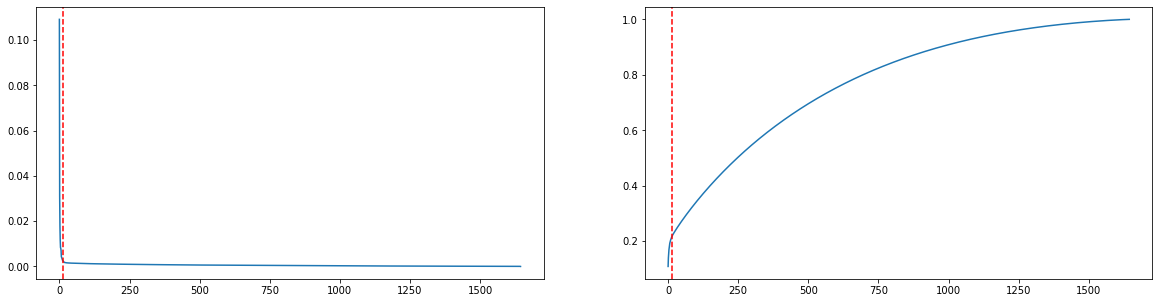

In [164]:
plt.figure(figsize=(20,5))
plt.subplot(121);plt.plot(percexp);plt.axvline(ind[-1],c='red',ls='--')
plt.subplot(122);plt.plot(np.cumsum(percexp));plt.axvline(ind[-1],c='red',ls='--')

In [30]:
adata = sc.read('../data/nestorowa_corrected_log2_transformed_counts.txt', cache=True)
cell_types = pd.read_csv('../data/nestorowa_corrected_population_annotation.txt', delimiter=' ')
# Replace the long names with the acronyms and make this a vector of the length of the number of observations.
acronyms = {'ESLAM': 'Stem', 'Erythroid': 'Ery', 'Megakaryocytes': 'Mk', 'Basophils': 'Baso',
            'Neutrophils': 'Neu', 'Monocytes': 'Mo', 'Bcell': 'B'}
cell_types = [acronyms[cell_types.loc[cell_id, 'celltype']]
              if cell_id in cell_types.index else 'no_gate' for cell_id in adata.obs_names]

numerical_labels=LabelEncoder().fit_transform(cell_types)
numerical_labels[numerical_labels==7]=-1

np.random.seed(0); umap_emb = umap.UMAP(n_neighbors=20).fit_transform(nestorowa,y=numerical_labels)

In [22]:
s=np.zeros(len(cell_types))
s[np.where(numerical_labels==-1)]=1

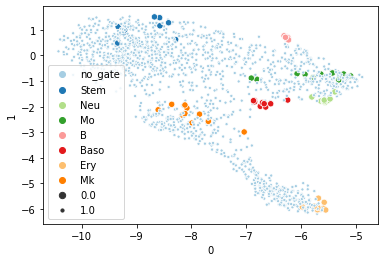

In [54]:
df=pd.DataFrame(umap_emb)
sns.scatterplot(df[0],df[1],
                hue=cell_types,
                palette=sns.color_palette('Paired', len(np.unique(cell_types))),
                size=s,
                sizes=[40,10])#;plt.title('Nestorowa')

## Load Paul et al

In [14]:
adata=sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


In [15]:
adata.uns['workdir']='../data/single_cell'

Filter genes based on min_num_cells
After filtering out low-expressed genes: 
2730 cells, 2987 genes
299 variable genes are selected


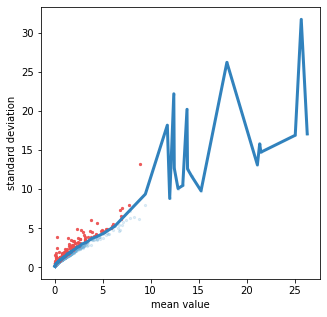

In [25]:
remove_mt_genes(adata)
filter_genes(adata,min_num_cells = 5)
select_variable_genes(adata,loess_frac=0.01, percentile=90)

In [21]:
adata.obsm['var_genes']

(2730, 299)

In [1]:
np.log2(adata.to_df().to_numpy())

NameError: name 'np' is not defined

### Global ID saturation analysis

In [ ]:
# testing separability saturation
n_repeats = 10
n_methods = 7
all_sample_sizes = [1,2,4,8,10,20,40,60,80]

for key,data in synthetic_data.items():
    
    datasets_done = [i.split('_')[0] for i in list(filter(lambda x: '.data' in x, os.listdir('../results')))]
    dataset_name = key
    n_samples = data.shape[0]
    
    if dataset_name in datasets_done:
        print('already computed ', dataset_name)
        continue
    
    print('\n',dataset_name)
    print('Running subsampling analysis...\nSubsample percentages = {}\nNumber of repeats = {}\nNumber of samples = {}\nDimension = {}'.format(all_sample_sizes,n_repeats,n_samples,data.shape[1]))
    print('----------------------------\n')
    seed = 0; np.random.seed(seed)
    print(f'Random seed set to {seed} before running the test')
    
    all_dim_estimates = np.zeros([n_methods,len(all_sample_sizes)+1,n_repeats])

    runtimes = []
    for i,sz in enumerate(all_sample_sizes):
        sample_size = int(n_samples*sz/100)
        print('Sample size = {}'.format(sample_size))
        start_time = time.time()
        for j in range(0,n_repeats):
            sample = np.random.choice(n_samples,replace=False, size=sample_size)
            xs = data[sample,:]

            #Run estimators
            allres = DE.estimateAllMethods(xs)
            results = allres[0]
            runtimes.append(allres[1])

            #Store
            for it,key in enumerate(results.keys()):
                all_dim_estimates[it,i,j] =  results[key]


        print("Elapsed time = {}".format(time.time()-start_time))

    allres = DE.estimateAllMethods(data)
    results = allres[0]
    runtimes.append(allres[1])

    for i in range(0,n_repeats):
        for it,key in enumerate(results.keys()):
            all_dim_estimates[it,len(all_sample_sizes),i] =  results[key]

    with open("../results/"+dataset_name+"_all_dim_estimates.npy",'wb') as f:
        pickle.dump(all_dim_estimates,f)
        
all_sample_sizes.append(100)
np.savetxt("../results/all_sample_sizes.txt", all_sample_sizes, delimiter="\t")
with open("../results/all_dim_estimates_keys.npy",'wb') as f:
        pickle.dump(list(results.keys()),f)

already computed  m1-00.data
already computed  m10a-00.data
already computed  m10b-00.data

 m10c-00.data
Running subsampling analysis...
Subsample percentages = [1, 2, 4, 8, 10, 20, 40, 60, 80]
Number of repeats = 2
Number of samples = 10000
Dimension = 25
----------------------------

Random seed set to 0 before running the test
Sample size = 100
Elapsed time = 14.658308982849121
Sample size = 200
Elapsed time = 13.042473077774048
Sample size = 400
Elapsed time = 13.147257089614868
Sample size = 800
Elapsed time = 13.323329210281372
Sample size = 1000
Elapsed time = 13.56218934059143
Sample size = 2000
Elapsed time = 15.96231722831726
Sample size = 4000
Elapsed time = 26.25061559677124
Sample size = 6000
Elapsed time = 33.37805151939392
Sample size = 8000
Elapsed time = 54.82598066329956

 m11-00.data
Running subsampling analysis...
Subsample percentages = [1, 2, 4, 8, 10, 20, 40, 60, 80]
Number of repeats = 2
Number of samples = 10000
Dimension = 3
----------------------------

Rand

In [ ]:
# plot convergence curve
alls=pd.read_csv('../results/all_sample_sizes.txt', sep='\t',header=None)
all_sample_sizes = alls.to_numpy()[:,0]

with open("../results/"+dataset_name+"_all_dim_estimates.npy",'rb') as f:
    all_dim_estimates = pickle.load(f)
    
with open("../results/all_dim_estimates_keys.npy",'rb') as f:
    estimators = pickle.load(f)

for i,estimator in enumerate(estimators):
    dim_estimates = all_dim_estimates[i]
    
    mn = np.mean(dim_estimates[:,:],1)
    std = np.std(dim_estimates[:,:],1)

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.title(estimator)
    plt.plot(all_sample_sizes,mn,'bs-')
    plt.plot(all_sample_sizes,mn-std,'r--')
    plt.plot(all_sample_sizes,mn+std,'r--')
    plt.plot(all_sample_sizes,dim_estimates,'b+')
    plt.xlabel('Percentage of points')
    plt.ylabel('Estimated intrinsic dimension')

### Local estimates convergence

In [ ]:
# testing separability saturation
n_jobs = 4
num_neighbors = num_neighbors = np.arange(50,450,50)
n_repeats = 10
n_methods = 18
all_sample_sizes = [1,2,4,8,10,20,40,60,80]


for n_neighbors in num_neighbors:

    for key,data in synthetic_data.items():

        datasets_done = [i.split('_')[0] for i in list(filter(lambda x: '.data' in x, os.listdir('../results')))]
        dataset_name = key
        n_samples = data.shape[0]

        if dataset_name in datasets_done:
            print('already computed ', dataset_name)
            continue

        print('\n',dataset_name)
        print('Running subsampling analysis...\nSubsample percentages = {}\nNumber of repeats = {}\nNumber of samples = {}\nDimension = {}'.format(all_sample_sizes,n_repeats,n_samples,data.shape[1]))
        print('----------------------------\n')
        print('kNN = ',n_neighbors)
        seed = 0; np.random.seed(seed)
        print(f'Random seed set to {seed} before running the test')

        all_dim_estimates = np.zeros([n_methods,len(all_sample_sizes)+1,n_repeats,len(data)])

        runtimes = []
        for i,sz in enumerate(all_sample_sizes):
            sample_size = int(n_samples*sz/100)
            if sample_size <= 2*n_neighbors:
                print(f'Sample size {sample_size} too small for chosen neighborhood {n_neighbors}. continue')
                continue
            else:
                print('Sample size = {}'.format(sample_size))
            start_time = time.time()
            for j in range(0,n_repeats):
                sample = np.random.choice(n_samples,replace=False, size=sample_size)
                xs = data[sample,:]

                #Run estimators
                allres = DE.estimateAllMethodsLocally(xs, k = n_neighbors, n_jobs = n_jobs, ConditionalNumber = 10)

                results = allres[0]
                runtimes.append(allres[1])

                #Store
                for it,key in enumerate(results.keys()):
                    all_dim_estimates[it,i,j,:len(xs)] =  results[key]


            print("Elapsed time = {}".format(time.time()-start_time))

        allres = DE.estimateAllMethodsLocally(data, k = n_neighbors, n_jobs = n_jobs, ConditionalNumber = 10)

        results = allres[0]
        runtimes.append(allres[1])

        for i in range(0,n_repeats):
            for it,key in enumerate(results.keys()):
                all_dim_estimates[it,len(all_sample_sizes),i,:len(data)] =  results[key]

        with open("../results/"+dataset_name+"_all_dim_estimates_kNN"+str(n_neighbors)+".npy",'wb') as f:
            pickle.dump(all_dim_estimates,f)

with open("../results/"+dataset_name+"_all_dim_estimates_keys_kNN"++str(n_neighbors)+".npy",'wb') as f:
        pickle.dump(list(results.keys()),f)

In [ ]:
# plot convergence curve (to modify for local id)
alls=pd.read_csv('../results/all_sample_sizes.txt', sep='\t',header=None)
all_sample_sizes = alls.to_numpy()[:,0]

with open("../results/"+dataset_name+"_all_dim_estimates.npy",'rb') as f:
    all_dim_estimates = pickle.load(f)
with open("../results/"+dataset_name+"_all_dim_estimates_keys_kNN"++str(n_neighbors)+".npy",'wb') as f:
    estimators = pickle.load(f)

for i,estimator in enumerate(estimators):
    dim_estimates = all_dim_estimates[i]
    
    mn = np.mean(dim_estimates[:,:],1)
    std = np.std(dim_estimates[:,:],1)

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.title(estimator)
    plt.plot(all_sample_sizes,mn,'bs-')
    plt.plot(all_sample_sizes,mn-std,'r--')
    plt.plot(all_sample_sizes,mn+std,'r--')
    plt.plot(all_sample_sizes,dim_estimates,'b+')
    plt.xlabel('Percentage of points')
    plt.ylabel('Estimated intrinsic dimension')

### Study kNN ID

In [152]:
num_neighbors = [50,100,200,300]
n_jobs = 4

#Run ID estimators pointwise in KNN neighborhoods of different sizes
for n_neighbors in num_neighbors:
    for dataset_name,data in [('nestorowaCond'+str(ConditionalNumber),pca_nestorowa)]:
    
        n_samples = data.shape[0]
        print(dataset_name)
        print('Running kNN ID for all estimators...\nNumber of samples = {}\nDimension = {}'.format(n_samples,data.shape[1]))
        print('----------------------------\n')
        print('kNN = ',n_neighbors)

        start_all=time.time()

        ests_pw_dict = DE.estimateAllMethodsLocally(data, k = n_neighbors, n_jobs = n_jobs)

        print('elapsed :',round(time.time()-start_all,2))

        with open('../results/ests_pw_dict_'+dataset_name+'_kNN'+str(n_neighbors)+'.pkl','wb') as f:
            pickle.dump(ests_pw_dict,f)

nestorowaCond50
Running kNN ID for all estimators...
Number of samples = 1645
Dimension = 15
----------------------------

kNN =  50


PicklingError: Can't pickle <function DimEst.fisherS at 0x7fc47a8abcb0>: it's not the same object as __main__.DimEst.fisherS

In [149]:
dataset_name='nestorowaCond'+str(ConditionalNumber)
n_neighbors = num_neighbors[1]

In [145]:
with open('../results/ests_pw_dict_'+dataset_name+'_kNN'+str(n_neighbors)+'.pkl','rb') as f:
    ests_pw_dict= pickle.load(f)

In [146]:
for i,est in enumerate(ests_pw):
    print(ests_pw_names[i],round(est.mean(),2))

MLE 4.89
MiND 8.01
FastDANCo 10.24
ESS 6.84
FisherS 13.48
ANOVA 4.63
TwoNN 9.0


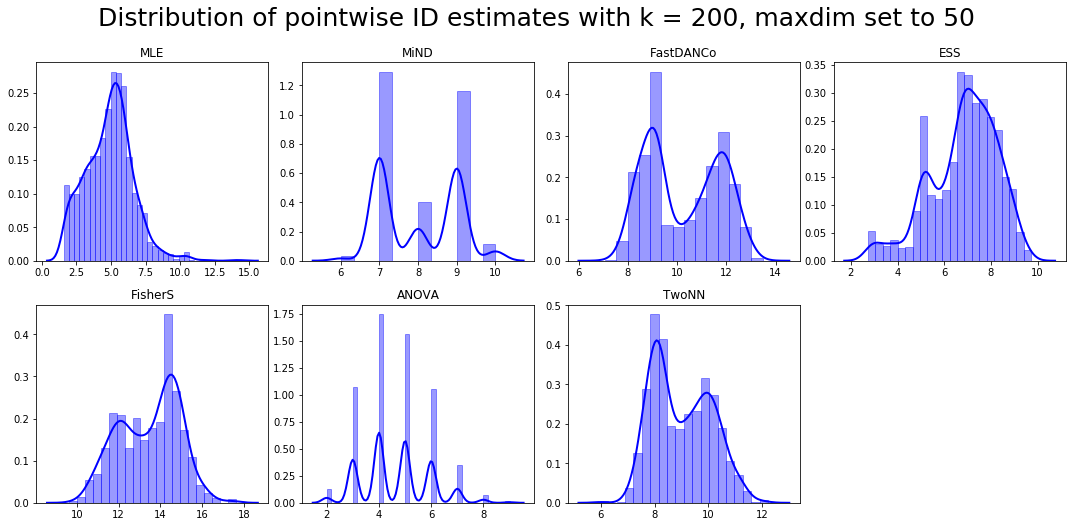

In [147]:
ests_pw = np.array([i for i in ests_pw_dict[0].values()])
ests_pw_names = list(ests_pw_dict[0].keys())

#plot distributions
plt.figure(figsize=(15,10))
xmin = 1
xmax = 50
#xmax = int(np.max(ests_pw)+2
for i,est in enumerate(ests_pw):
    plt.subplot(3,4,i+1)
    plt.title(ests_pw_names[i])
    sns.distplot(est, hist=True, kde=True, color = 'blue', 
                 hist_kws={'edgecolor':'blue'},
                 kde_kws={'linewidth': 2})
    #plt.xlim(xmin,xmax)
    #plt.xticks(list(range(int(xmin),int(xmax),4)))
plt.tight_layout()
plt.suptitle('Distribution of pointwise ID estimates with k = {}, maxdim set to {}'.format(n_neighbors,xmax),y=1.04, fontsize=25)
plt.show()

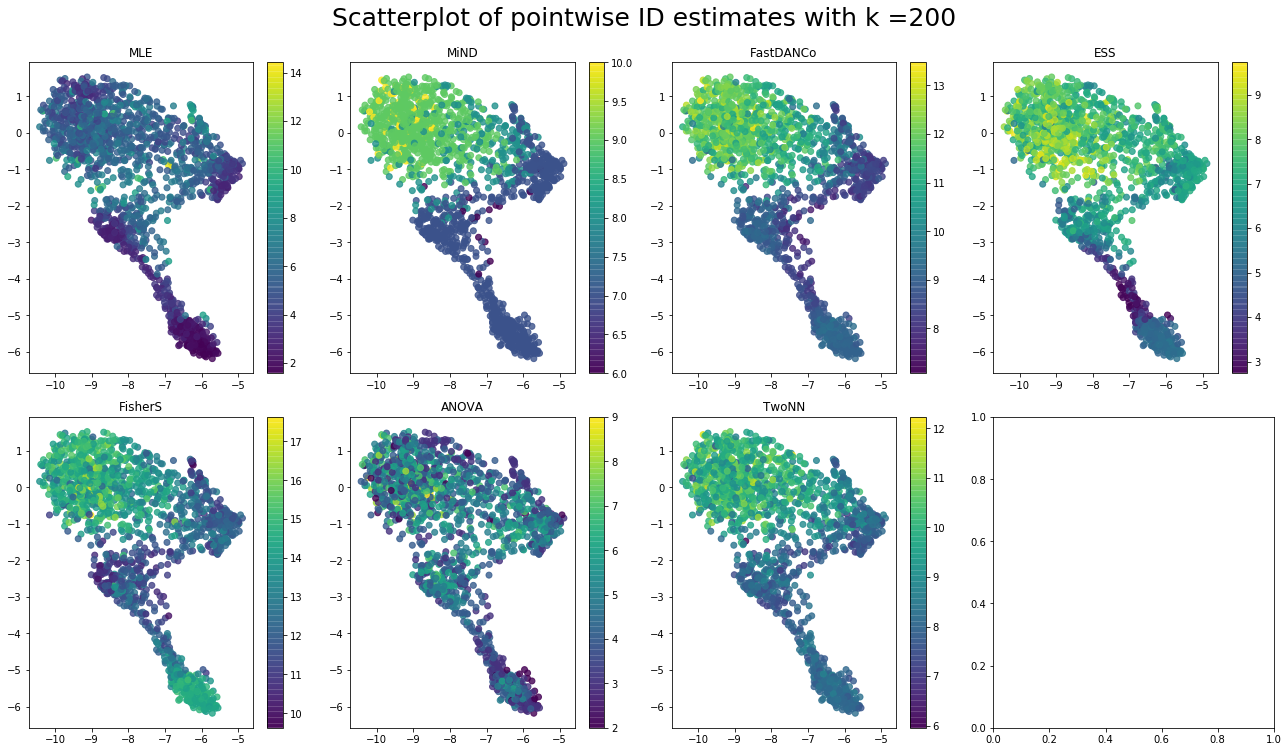

In [151]:
filter_high_id = False #value or False

fig, axs = plt.subplots(2,4,figsize=(18,10))
axes = list(axs.flat)
plt.suptitle('Scatterplot of pointwise ID estimates with k ={}'.format(n_neighbors),y=1.04,fontsize=25)
for i,est in enumerate(ests_pw):
    axes[i].set_title(ests_pw_names[i])
    _subplot = axes[i].scatter(umap_emb[:,0],umap_emb[:,1],
                               c=est,alpha=.8)
    plt.colorbar(_subplot, ax=axes[i])

plt.tight_layout()
plt.show()

### Study global pointwise ID

In [65]:
list_global_id = []
list_inseparability_id = []
for dataset_name,data in  [('nestorowa',pca_nestorowa)]:

    print(dataset_name)
    start_all=time.time()

    [n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(data,ProducePlots=0,ncomp=1,
                                                                                   ConditionalNumber=60,alphas=np.arange(.2,1,.02)[None])
    n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='all_inseparable')

    list_global_id.append(n_single[0])
    list_inseparability_id.append(n_pointwise)

    print('elapsed :',round(time.time()-start_all,2))

nestorowa
15 components are retained using factor 60.00
1645/1645 points have nonzero inseparability probability for chosen alpha = 0.66
elapsed : 0.33


In [68]:
knndists,knnidx = get_nn(data,k=n_neighbors)
pw_res = asPointwise(data,SeparabilityAnalysis,params=dict(ProducePlots=0,alphas=np.arange(.2,1,.02)[None],ncomp=0),precomputed_knn=knnidx)
n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='all_inseparable')

local_id = np.array([i[1][0] for i in pw_res])

1645/1645 points have nonzero inseparability probability for chosen alpha = 0.66


In [78]:
def mean_local_id(local_id,knnidx):
    '''
    Compute point mean local ID: the mean ID of all neighborhoods in which a point appears (can be NaN if the point never appears)
    Inputs :
    local_id : list or np.array
        list of local ID for each point
    knnidx : indices of kNN for each point
    '''
    mean_neighborhoods_LID = np.zeros(len(local_id))
    for point_i in range(len(local_id)):
        # get all points which have this point in their neighbourhoods
        all_neighborhoods_with_point_i = np.where(knnidx==point_i)[0]
        # get the local ID associated with each of these points
        mean_neighborhoods_LID[point_i] = (local_id[all_neighborhoods_with_point_i].mean())
    return mean_neighborhoods_LID

def mean_of_local_global_pointwise_id(pw_res,knnidx,idx):
    '''
    Compute point mean local global pointwise ID: the mean global pointwise ID computed in each neighborhood where a point appears
    Inputs :
    pw_res : list of np array
        full output of asPointwise(SeparabilityAnalysis)
    knnidx : np.array
        indices of kNN for each point
    idx : integer
    selected alpha index
    '''
    # parse input
    local_n_alpha = np.array([i[0] for i in pw_res])
    local_n_single = np.array([i[1] for i in pw_res])
    local_p_alpha = np.array([i[2] for i in pw_res])
    
    index_points = np.arange(len(pw_res))    
    mean_n_pointwise = np.zeros(len(pw_res))
    all_neighborhoods_n_pointwise = []
    for point_i in range(len(pw_res)):
        # get all points which have this point in their neighbourhoods
        all_neighborhoods_with_point_i = np.argwhere(knnidx==point_i)

        if len(all_neighborhoods_with_point_i) == 0:
            mean_n_pointwise[point_i] = np.nan
            all_neighborhoods_n_pointwise.append(np.nan)

            continue

        # get "local global" pw IDs for point_i
        neighborhoods_n_pointwise = []
        for neighborhood_idx,point_idx in all_neighborhoods_with_point_i:
            n_pointwise, _ = point_inseparability_to_pointID(local_n_alpha[neighborhood_idx],
                                                               local_n_single[neighborhood_idx],
                                                               local_p_alpha[neighborhood_idx],
                                                               alphas,
                                                               idx=idx,verbose=False)
            neighborhoods_n_pointwise.append(n_pointwise[point_idx])
            
        # store distribution
        all_neighborhoods_n_pointwise.append(neighborhoods_n_pointwise)
        # get "mean local global" pw ID for point_i
        mean_n_pointwise[point_i] = np.nanmean(neighborhoods_n_pointwise)
    return mean_n_pointwise, all_neighborhoods_n_pointwise

In [71]:
mean_neighborhoods_LID = mean_local_id(local_id,knnidx)

In [91]:
mean_n_pointwise, all_neighborhoods_n_pointwise = mean_of_local_global_pointwise_id(pw_res,knnidx, idx=23)#(n_alpha==n_single).tolist().index(True))

1645/1645 points have nonzero inseparability probability for chosen alpha = 0.66
800/1645 points have nonzero inseparability probability for chosen alpha = 0.88




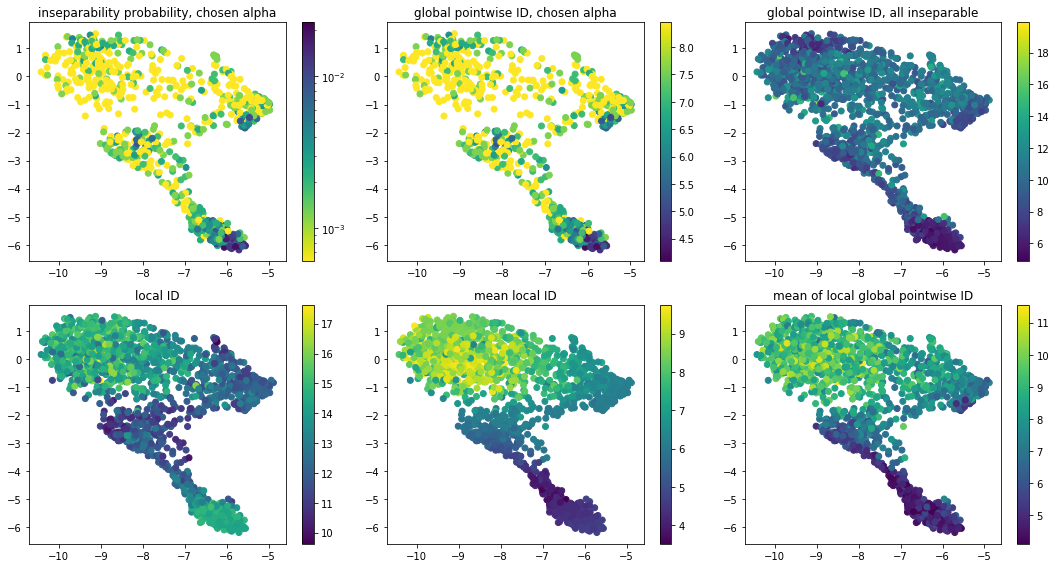

In [141]:
selected_idx = (n_alpha==n_single).tolist().index(True)
n_pointwise_inseparable, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='all_inseparable')
n_pointwise_selected, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected')
print('\n')

plt.figure(figsize=(15,8))

plt.subplot(231);plt.scatter(umap_emb[:,0],umap_emb[:,1],c=p_alpha[selected_idx],norm=mpl.colors.LogNorm(),cmap='viridis_r');plt.colorbar();plt.title('inseparability probability, chosen alpha')
plt.subplot(232);plt.scatter(umap_emb[:,0],umap_emb[:,1],c=n_pointwise_selected);plt.colorbar();plt.title('global pointwise ID, chosen alpha')
plt.subplot(233);plt.scatter(umap_emb[:,0],umap_emb[:,1],c=n_pointwise_inseparable);plt.colorbar();plt.title('global pointwise ID, all inseparable')
plt.subplot(234);plt.scatter(umap_emb[:,0],umap_emb[:,1],c=ests_pw_dict[0]['FisherS']);plt.colorbar();plt.title('local ID')
plt.subplot(235);plt.scatter(umap_emb[:,0],umap_emb[:,1],c=mean_neighborhoods_LID);plt.colorbar();plt.title('mean local ID')
plt.subplot(236);plt.scatter(umap_emb[:,0],umap_emb[:,1],c=mean_n_pointwise);plt.colorbar();plt.title('mean of local global pointwise ID')
plt.tight_layout();plt.show()

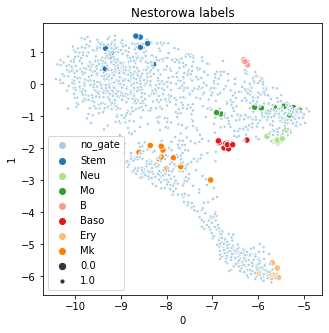

In [108]:
plt.figure(figsize=(5,5))
sns.scatterplot(df[0],df[1],
                hue=cell_types,
                palette=sns.color_palette('Paired', len(np.unique(cell_types))),
                size=s,
                sizes=[40,10]);plt.title('Nestorowa labels');plt.show()

In [110]:
from feature_engine.discretisers import DecisionTreeDiscretiser
treeDisc = DecisionTreeDiscretiser(cv=10, scoring='accuracy',
                                   regression=False,
                                   param_grid={'max_depth': [1,2,3],
'min_samples_leaf':[10,4]})

In [111]:
treeDisc.fit(pd.DataFrame(est[:,None]),est)

ValueError: Unknown label type: 'continuous'

### Study the behavior of the statistics used by the various estimators